In [1]:
import numpy as np
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer,tokenizer_from_json
import pandas as pd
from nltk.corpus import stopwords
import re
import json
STOPWORDS = set(stopwords.words('english'))
import os

In [2]:
embedding_dim=100
oov_token = '<OOV>'
train_test_split = 0.8
max_len = 200
trunc_type = 'post'
padding_type = 'post'

In [3]:
df = pd.read_csv("../unsup.csv")
df["label"]=df["label"].replace({1,0},{"Positive","Negative"})
labels = df.get('label').values.tolist()
articles = df.get('sentence').values.tolist()
for i in range(len(articles)):
    for word in STOPWORDS:
        token = ' '+word+' '
        articles[i] = articles[i].replace(token,' ')
        articles[i] = re.sub(r'\s+', ' ',articles[i])

In [4]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(articles)
sequences = tokenizer.texts_to_sequences(articles)
article_sequences = pad_sequences(sequences,maxlen=max_len,truncating=trunc_type,padding=padding_type)
word_index = tokenizer.word_index
vocab_size = len(word_index)

split_index = int(len(article_sequences)*train_test_split)
train_sequences = np.array(article_sequences[0:split_index])
test_sequences = np.array(article_sequences[split_index:])

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_sequences = label_tokenizer.texts_to_sequences(labels)
train_label = np.array(label_sequences[0:split_index])
test_label = np.array(label_sequences[split_index:])

In [5]:
tokenizer_json = tokenizer.to_json()
label_tokenizer_json = label_tokenizer.to_json()

In [6]:
embeddings_index = {};
with open('../../glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [7]:
if not os.path.exists('tokenizer.json'):
    with open('tokenizer.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
if not os.path.exists('label_tokenizer_json.json'):
    with open('label_tokenizer_json.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(label_tokenizer_json, ensure_ascii=False))

In [8]:
np.save('train_sequences.npy',train_sequences)
np.save('train_label.npy',train_label)
np.save('test_sequences.npy',test_sequences)
np.save('test_label.npy',test_label)
np.save('embeddings_matrix.npy',embeddings_matrix)

In [9]:
print(train_sequences.shape)
print(train_label.shape)
print(test_sequences.shape)
print(test_label.shape)
print(vocab_size)
print(word_index['i'])

(7690, 200)
(7690, 1)
(1923, 200)
(1923, 1)
17077
11


In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, LSTM, Embedding,Conv2D,Bidirectional,MaxPool2D,Reshape
from keras.models import load_model
from keras.preprocessing.text import Tokenizer,tokenizer_from_json
from keras.callbacks import ModelCheckpoint
import json
import os
import datetime as dt
from matplotlib import pyplot as plt

In [11]:
with open('tokenizer.json', 'r', encoding='utf-8') as f1:
    tokenizer_config = json.load(f1)
with open('label_tokenizer_json.json', 'r', encoding='utf-8') as f2:
    label_tokenizer_config = json.load(f2)

In [3]:
train_sequences= np.load('train_sequences.npy')
train_label= np.load('train_label.npy')
test_sequences = np.load('test_sequences.npy')
test_label= np.load('test_label.npy')
embeddings_matrix= np.load('embeddings_matrix.npy')

In [13]:
tokenizer = tokenizer_from_json(tokenizer_config)
label_tokenizer = tokenizer_from_json(label_tokenizer_config)

In [14]:
embedding_dim = 100
word_index = word_index
vocab_size = vocab_size
max_len = 200
rnn_units = 100

In [15]:
model = Sequential()
model.add(Embedding(vocab_size+1,embedding_dim,input_length=max_len,weights=[embeddings_matrix], trainable=False))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(rnn_units,return_sequences=True),merge_mode='sum'))
model.add(Dropout(0.2))
model.add(Reshape((-1,rnn_units,1)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adadelta',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1707800   
                                                                 
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 100)         160800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200, 100)          0         
                                                                 
 reshape (Reshape)           (None, 200, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 98, 64)       640       
                                                        

In [16]:
epochs = 10
save_dir = './saved_model'
save_fname = os.path.join(save_dir, "情感2.h5")
callbacks = [ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 114s 451ms/step - loss: 1.0424 - accuracy: 0.4983 - val_loss: 1.0115 - val_accuracy: 0.5231
Epoch 2/10
241/241 [==============================] - 86s 355ms/step - loss: 0.9420 - accuracy: 0.5254 - val_loss: 0.9338 - val_accuracy: 0.4977
Epoch 3/10
241/241 [==============================] - 76s 317ms/step - loss: 0.8604 - accuracy: 0.5202 - val_loss: 0.8573 - val_accuracy: 0.4977
Epoch 4/10
241/241 [==============================] - 99s 411ms/step - loss: 0.7936 - accuracy: 0.5208 - val_loss: 0.7940 - val_accuracy: 0.4977
Epoch 5/10
241/241 [==============================] - 140s 583ms/step - loss: 0.7494 - accuracy: 0.5213 - val_loss: 0.7542 - val_accuracy: 0.4977
Epoch 6/10
241/241 [==============================] - 135s 560ms/step - loss: 0.7257 - accuracy: 0.5213 - val_loss: 0.7316 - val_accuracy: 0.4977
Epoch 7/10
241/241 [==============================] - 89s 368ms/step - loss: 0.7124 - accuracy: 0.5303 - val_loss: 0.7198 - val

In [17]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 130s 541ms/step - loss: 0.6961 - accuracy: 0.5343 - val_loss: 0.7003 - val_accuracy: 0.4982
Epoch 2/10
241/241 [==============================] - 134s 557ms/step - loss: 0.6947 - accuracy: 0.5368 - val_loss: 0.6983 - val_accuracy: 0.4982
Epoch 3/10
241/241 [==============================] - 115s 477ms/step - loss: 0.6931 - accuracy: 0.5315 - val_loss: 0.6960 - val_accuracy: 0.5517
Epoch 4/10
241/241 [==============================] - 99s 412ms/step - loss: 0.6923 - accuracy: 0.5430 - val_loss: 0.6949 - val_accuracy: 0.5096
Epoch 5/10
241/241 [==============================] - 101s 418ms/step - loss: 0.6916 - accuracy: 0.5380 - val_loss: 0.6933 - val_accuracy: 0.5741
Epoch 6/10
241/241 [==============================] - 101s 418ms/step - loss: 0.6907 - accuracy: 0.5490 - val_loss: 0.6921 - val_accuracy: 0.5819
Epoch 7/10
241/241 [==============================] - 100s 416ms/step - loss: 0.6892 - accuracy: 0.5538 - val_loss: 0.6911 - 

In [23]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 117s 473ms/step - loss: 0.6875 - accuracy: 0.5610 - val_loss: 0.6885 - val_accuracy: 0.5211
Epoch 2/10
241/241 [==============================] - 149s 620ms/step - loss: 0.6871 - accuracy: 0.5547 - val_loss: 0.6876 - val_accuracy: 0.5387
Epoch 3/10
241/241 [==============================] - 147s 609ms/step - loss: 0.6864 - accuracy: 0.5585 - val_loss: 0.6860 - val_accuracy: 0.6479
Epoch 4/10
241/241 [==============================] - 111s 459ms/step - loss: 0.6858 - accuracy: 0.5767 - val_loss: 0.6858 - val_accuracy: 0.5788
Epoch 5/10
241/241 [==============================] - 104s 430ms/step - loss: 0.6851 - accuracy: 0.5691 - val_loss: 0.6850 - val_accuracy: 0.5970
Epoch 6/10
241/241 [==============================] - 104s 431ms/step - loss: 0.6850 - accuracy: 0.5666 - val_loss: 0.6843 - val_accuracy: 0.6058
Epoch 7/10
241/241 [==============================] - 106s 440ms/step - loss: 0.6847 - accuracy: 0.5707 - val_loss: 0.6835 -

In [26]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 141s 584ms/step - loss: 0.6819 - accuracy: 0.5912 - val_loss: 0.6813 - val_accuracy: 0.5855
Epoch 2/10
241/241 [==============================] - 143s 592ms/step - loss: 0.6815 - accuracy: 0.5758 - val_loss: 0.6798 - val_accuracy: 0.6708
Epoch 3/10
241/241 [==============================] - 106s 439ms/step - loss: 0.6808 - accuracy: 0.5978 - val_loss: 0.6799 - val_accuracy: 0.6022
Epoch 4/10
241/241 [==============================] - 102s 425ms/step - loss: 0.6811 - accuracy: 0.5800 - val_loss: 0.6784 - val_accuracy: 0.6708
Epoch 5/10
241/241 [==============================] - 101s 419ms/step - loss: 0.6800 - accuracy: 0.5977 - val_loss: 0.6781 - val_accuracy: 0.6318
Epoch 6/10
241/241 [==============================] - 104s 432ms/step - loss: 0.6795 - accuracy: 0.5965 - val_loss: 0.6771 - val_accuracy: 0.6594
Epoch 7/10
241/241 [==============================] - 123s 509ms/step - loss: 0.6783 - accuracy: 0.6060 - val_loss: 0.6767 -

In [29]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 114s 474ms/step - loss: 0.6768 - accuracy: 0.6057 - val_loss: 0.6740 - val_accuracy: 0.6303
Epoch 2/10
241/241 [==============================] - 111s 460ms/step - loss: 0.6755 - accuracy: 0.6010 - val_loss: 0.6723 - val_accuracy: 0.6947
Epoch 3/10
241/241 [==============================] - 108s 450ms/step - loss: 0.6752 - accuracy: 0.6215 - val_loss: 0.6722 - val_accuracy: 0.6459
Epoch 4/10
241/241 [==============================] - 107s 445ms/step - loss: 0.6751 - accuracy: 0.6159 - val_loss: 0.6712 - val_accuracy: 0.6599
Epoch 5/10
241/241 [==============================] - 108s 449ms/step - loss: 0.6744 - accuracy: 0.6173 - val_loss: 0.6708 - val_accuracy: 0.6427
Epoch 6/10
241/241 [==============================] - 109s 452ms/step - loss: 0.6740 - accuracy: 0.6103 - val_loss: 0.6694 - val_accuracy: 0.6729
Epoch 7/10
241/241 [==============================] - 111s 462ms/step - loss: 0.6726 - accuracy: 0.6273 - val_loss: 0.6692 -

In [5]:
epochs = 10
save_dir = './saved_model'
save_fname = os.path.join(save_dir, "情感2.h5")
callbacks = [ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 112s 454ms/step - loss: 0.6703 - accuracy: 0.6226 - val_loss: 0.6654 - val_accuracy: 0.6583
Epoch 2/10
241/241 [==============================] - 109s 454ms/step - loss: 0.6704 - accuracy: 0.6231 - val_loss: 0.6647 - val_accuracy: 0.6542
Epoch 3/10
241/241 [==============================] - 115s 475ms/step - loss: 0.6689 - accuracy: 0.6285 - val_loss: 0.6634 - val_accuracy: 0.6667
Epoch 4/10
241/241 [==============================] - 108s 447ms/step - loss: 0.6689 - accuracy: 0.6226 - val_loss: 0.6620 - val_accuracy: 0.6989
Epoch 5/10
241/241 [==============================] - 106s 441ms/step - loss: 0.6679 - accuracy: 0.6328 - val_loss: 0.6611 - val_accuracy: 0.6994
Epoch 6/10
241/241 [==============================] - 104s 432ms/step - loss: 0.6676 - accuracy: 0.6390 - val_loss: 0.6607 - val_accuracy: 0.6677
Epoch 7/10
241/241 [==============================] - 106s 440ms/step - loss: 0.6653 - accuracy: 0.6402 - val_loss: 0.6593 -

In [6]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 109s 454ms/step - loss: 0.6630 - accuracy: 0.6402 - val_loss: 0.6552 - val_accuracy: 0.6849
Epoch 2/10
241/241 [==============================] - 115s 478ms/step - loss: 0.6631 - accuracy: 0.6368 - val_loss: 0.6538 - val_accuracy: 0.7057
Epoch 3/10
241/241 [==============================] - 111s 462ms/step - loss: 0.6615 - accuracy: 0.6455 - val_loss: 0.6526 - val_accuracy: 0.7135
Epoch 4/10
241/241 [==============================] - 112s 464ms/step - loss: 0.6601 - accuracy: 0.6486 - val_loss: 0.6520 - val_accuracy: 0.6802
Epoch 5/10
241/241 [==============================] - 110s 458ms/step - loss: 0.6592 - accuracy: 0.6449 - val_loss: 0.6503 - val_accuracy: 0.7119
Epoch 6/10
241/241 [==============================] - 115s 479ms/step - loss: 0.6591 - accuracy: 0.6518 - val_loss: 0.6494 - val_accuracy: 0.6973
Epoch 7/10
241/241 [==============================] - 114s 472ms/step - loss: 0.6576 - accuracy: 0.6527 - val_loss: 0.6481 -

In [9]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 115s 476ms/step - loss: 0.6543 - accuracy: 0.6521 - val_loss: 0.6432 - val_accuracy: 0.7036
Epoch 2/10
241/241 [==============================] - 113s 471ms/step - loss: 0.6533 - accuracy: 0.6560 - val_loss: 0.6420 - val_accuracy: 0.6994
Epoch 3/10
241/241 [==============================] - 111s 460ms/step - loss: 0.6524 - accuracy: 0.6601 - val_loss: 0.6410 - val_accuracy: 0.6906
Epoch 4/10
241/241 [==============================] - 111s 459ms/step - loss: 0.6521 - accuracy: 0.6505 - val_loss: 0.6393 - val_accuracy: 0.7093
Epoch 5/10
241/241 [==============================] - 113s 469ms/step - loss: 0.6518 - accuracy: 0.6497 - val_loss: 0.6380 - val_accuracy: 0.7057
Epoch 6/10
241/241 [==============================] - 115s 478ms/step - loss: 0.6491 - accuracy: 0.6610 - val_loss: 0.6371 - val_accuracy: 0.6927
Epoch 7/10
241/241 [==============================] - 114s 473ms/step - loss: 0.6504 - accuracy: 0.6494 - val_loss: 0.6359 -

In [11]:
model.fit(train_sequences,train_label,epochs=epochs,validation_data=(test_sequences,test_label),callbacks=callbacks)

Epoch 1/10
241/241 [==============================] - 108s 450ms/step - loss: 0.6445 - accuracy: 0.6671 - val_loss: 0.6300 - val_accuracy: 0.7031
Epoch 2/10
241/241 [==============================] - 115s 479ms/step - loss: 0.6434 - accuracy: 0.6609 - val_loss: 0.6284 - val_accuracy: 0.7161
Epoch 3/10
241/241 [==============================] - 114s 473ms/step - loss: 0.6434 - accuracy: 0.6644 - val_loss: 0.6284 - val_accuracy: 0.6906
Epoch 4/10
241/241 [==============================] - 116s 483ms/step - loss: 0.6419 - accuracy: 0.6563 - val_loss: 0.6260 - val_accuracy: 0.7036
Epoch 5/10
241/241 [==============================] - 116s 482ms/step - loss: 0.6407 - accuracy: 0.6642 - val_loss: 0.6244 - val_accuracy: 0.7051
Epoch 6/10
241/241 [==============================] - 114s 474ms/step - loss: 0.6394 - accuracy: 0.6631 - val_loss: 0.6226 - val_accuracy: 0.7166
Epoch 7/10
241/241 [==============================] - 116s 482ms/step - loss: 0.6374 - accuracy: 0.6711 - val_loss: 0.6215 -

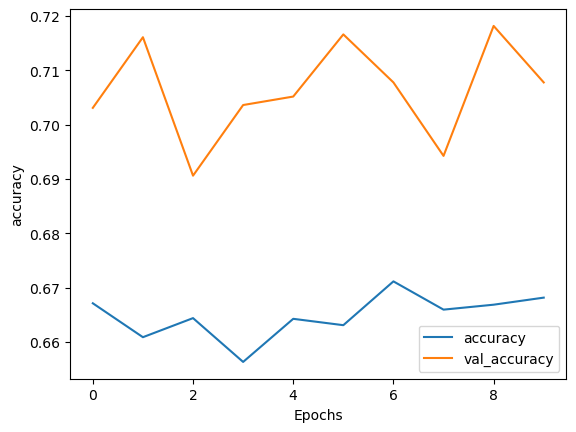

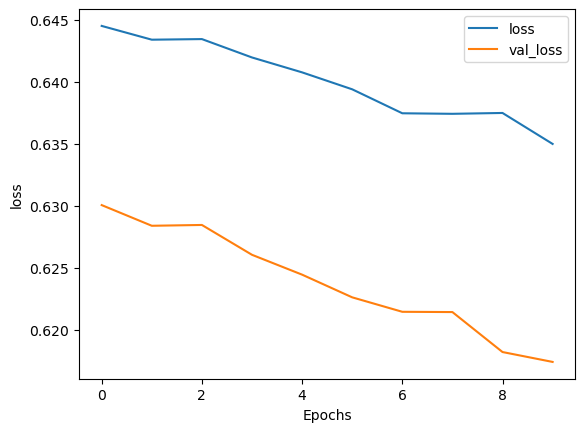

In [12]:
history = model.history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [23]:
import joblib
joblib.dump(model,"情感分析.pkl")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\bidirectional
......vars
...layers\bidirectional\backward_layer
......vars
...layers\bidirectional\backward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\forward_layer
......vars
...layers\bidirectional\forward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\layer
......vars
...layers\bidirectional\layer\cell
......vars
...layers\conv2d
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\embedding
......vars
.........0
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\reshape
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
......

['情感分析.pkl']

In [18]:
from keras.models import load_model
import numpy as np
import json
from keras.preprocessing.text import Tokenizer,tokenizer_from_json

In [25]:
from keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [4]:
model = load_model('./saved_model/情感2.h5')